# Setup

In [111]:
# was needed to download files from repo

# Download TorchVision repo to use some files from
# references/detection
# !git clone https://github.com/pytorch/vision.git
# !cd vision
# !git checkout v0.3.0

# !cp references/detection/utils.py ../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../

# Imports

In [112]:
import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone.core.labels import Detection
from PIL import Image

import torch
import torch.nn as nn
import torch.utils
import torch.utils.data

import torchvision
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

import matplotlib.pyplot as plt

import os
import importlib

import utils
import train
from train import train_one_epoch, evaluate
import transforms
import DatasetLoaders
importlib.reload(DatasetLoaders)
from DatasetLoaders import HRSIDDataset


In [113]:
importlib.reload(utils)
importlib.reload(transforms)
importlib.reload(train)

<module 'train' from '/home/k3vinli/ENEE439/Capstone/train.py'>

# loading data into fiftyone

In [114]:
# Loading Dataset
name = "HRSID"
if name in fo.list_datasets():
    dataset_traintest = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_traintest = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        name=name,
    )

In [115]:
name = "HRSID_train"
if name in fo.list_datasets():
    dataset_train = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    label_path = os.path.abspath("Datasets/HRSID/annotations/train2017.json")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_train = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        name=name,
        labels_path=label_path
    )

In [116]:
name = "HRSID_test"
if name in fo.list_datasets():
    dataset_test = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    label_path = os.path.abspath("Datasets/HRSID/annotations/test2017.json")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_test = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        name=name,
        labels_path=label_path
    )

In [117]:
dataset_train.compute_metadata()
dataset_test.compute_metadata()

# explore fiftyone useage

In [118]:
paths = dataset_train.values("filepath")
sample = dataset_train[paths[1]]
sample.metadata

<ImageMetadata: {
    'size_bytes': None,
    'mime_type': None,
    'width': 800,
    'height': 800,
    'num_channels': None,
}>

In [119]:
#sample

In [120]:
img = Image.open(paths[1]).convert("RGB")
detections = sample["detections"].detections
segmentations = sample["segmentations"].detections

In [121]:
classes = dataset_train.distinct("%s.detections.label" % "segmentations")

In [122]:
# segmentations

In [123]:
labels_map_rev = {c: i for i, c in enumerate(classes)}
labels_map_rev


{'ship': 0}

In [124]:
for det in segmentations:
    category_id=labels_map_rev[det.label]
    coco_obj=fouc.COCOObject.from_label(det, sample.metadata, category_id=category_id)
    x,y,w,h=coco_obj.bbox

In [125]:
# [coco_obj.segmentation], dtype=torch.float

In [126]:
sample = dataset_test.first()
frame_size = (sample.metadata["width"], sample.metadata["height"])
detection = sample["segmentations"]["detections"][0]

segmentation = detection.to_segmentation(frame_size=frame_size)
full_img_mask = segmentation.mask
print(type(detection))
print("frame size", frame_size)
print("detection:", detection)
print("segmentation:", segmentation)
print("full img", full_img_mask.max())

<class 'fiftyone.core.labels.Detection'>
frame size (800, 800)
detection: <Detection: {
    'id': '64422a7ba776879d966a5afd',
    'attributes': {},
    'tags': [],
    'label': 'ship',
    'bounding_box': [0.29625, 0.09875, 0.0525, 0.01],
    'mask': array([[False, False, False, False, False, False, False, False, False,
            False, False, False, False, False, False, False,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True, False, False, False, False],
           [False,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True, False],
           [ True,  True,  True,  True,  Tr


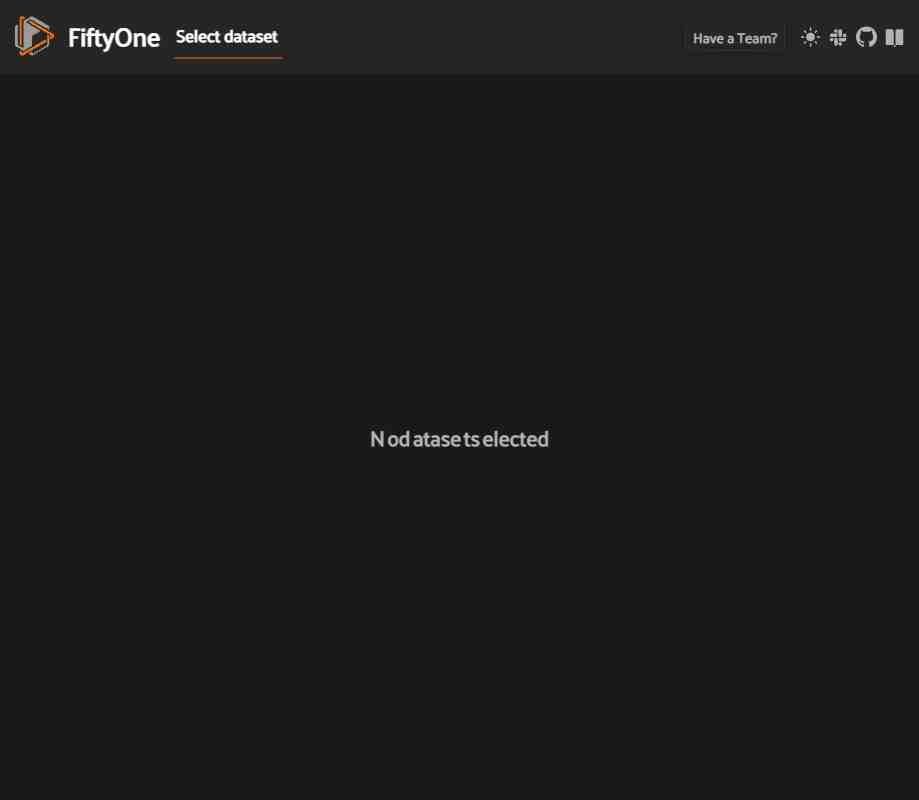

In [127]:
session = fo.launch_app()

# Training ResNet Model

In [128]:
def get_model(num_classes):
    weights = FCN_ResNet50_Weights.DEFAULT
    model = fcn_resnet50(weights=weights, classes=num_classes)

    return model

In [129]:
def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=2, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn
    )

    device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=5,
                                                    gamma=0.1)
    for epoch in range(num_epochs):
        train_one_epoch(model=model,
                        criterion=criterion,
                        optimizer=optimizer, 
                        data_loader=data_loader,
                        lr_scheduler=lr_scheduler,
                        device=device, 
                        epoch=epoch, 
                        print_freq=10)

        evaluate(model=model, data_loader=data_loader_test, device=device)

In [130]:
train_transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float)])
test_transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float)])
HRSID_train = HRSIDDataset(dataset_train, transforms=train_transform)
HRSID_test = HRSIDDataset(dataset_test, transforms=test_transform)

In [131]:
model = get_model(2)

In [132]:
do_training(model, HRSID_train, HRSID_test, num_epochs=20)


Using cpu
frame_size (800, 800)
mask shape torch.Size([13, 800, 800])
frame_size (800, 800)
mask shape torch.Size([5, 800, 800])


ValueError: only one element tensors can be converted to Python scalars


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

